# Homework3_2

Выполнил: Касенов Султан

В данной работе попытаемся обучить модели классификации, которые будут предсказывать отток пользователей на базе банковского датасета. Для начала импортируем все нужные библиотеки. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.datasets
from sklearn.model_selection import train_test_split
import sklearn.compose

Скачаем наш датасет и сразу проверим его на наличие NaN values. 

In [2]:
df = pd.read_csv('http://www.soshnikov.com/temp/data/BankChurnersProcessed.zip', compression='zip')

Значение false означает, что нам повезло и таких значений нету.

In [ ]:
df.isna().any().any()

False

Теперь можно рассмотреть датасет и начать его чистку.



In [ ]:
df

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,...,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000


## **Data cleaning**

Некоторые колонны таблицы имеют значения 'Unknown' и они не несут для нас никакой полезной информации. Проверить это можно, запустив код ниже. 

In [ ]:
print(df['Income_Category'].unique())
print(df['Marital_Status'].unique())
print(df['Education_Level'].unique())



['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']
['Married' 'Single' 'Unknown' 'Divorced']
['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate']


Поэтому мы заменим все значения 'Unknown' на моду данной колонны. Также мы сразу заменим пол ('Gender') пользователей на 0 или 1. 

In [3]:
df['Gender'] = df['Gender'].map({'M':0, 'F': 1})
df['Income_Category'].replace('Unknown', df['Income_Category'].mode()[0], inplace=True)
df['Marital_Status'].replace('Unknown', df['Marital_Status'].mode()[0], inplace=True)
df['Education_Level'].replace('Unknown', df['Education_Level'].mode()[0], inplace=True)

Классификация будет проводиться по значениям колоны 'Attrition_Flag', однако данные здесь имеют тип string, и поэтому создадим новое поле "Churn" которое будет иметь тип boolean (0, 1). 

In [4]:
df['Churn'] = df['Attrition_Flag'].map({'Existing Customer': 0, 'Attrited Customer':1})

Далее расмотрим графики распределения численных признаков.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f70378dfa60>,
      dtype=object)

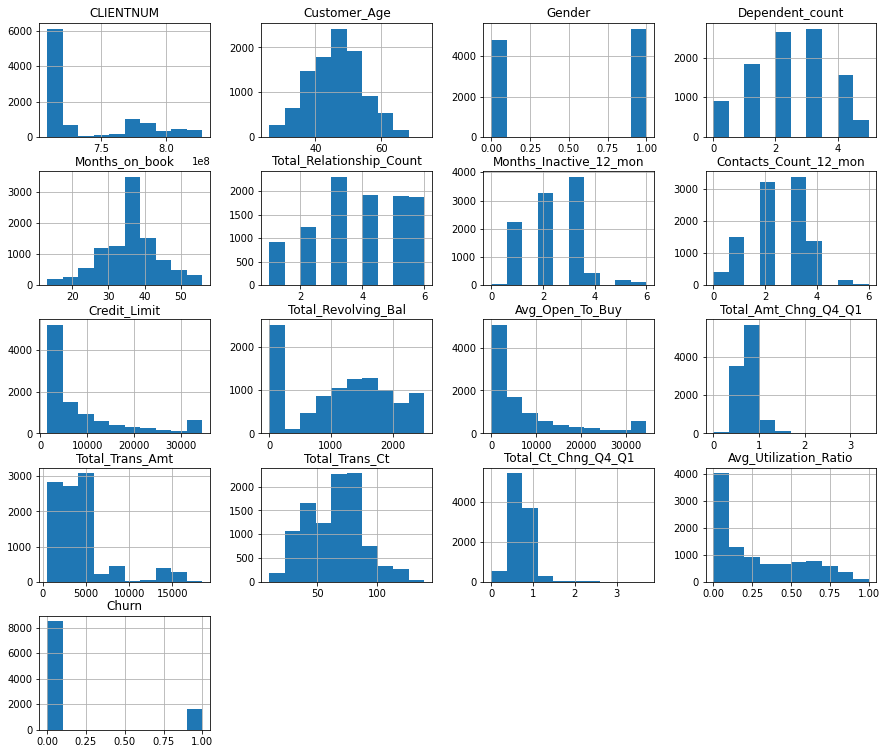

In [ ]:
df.hist(figsize=(15,13))

Следует отметить, что некоторые значения имеют смещенное распределение. Поэтому еще одно изменение, которое мы сделаемб,- это найдем логарифмы значений для данных колон.

In [5]:
df['log_Credit_Limit'] = np.log(df['Credit_Limit'])
df['log_Avg_Open_To_Buy'] = np.log(df['Avg_Open_To_Buy'])
df['log_Total_Trans_Amt'] = np.log(df['Total_Trans_Amt'])

Выделим категориальные и численные признаки, а также уберем несколько ненужных признаков. 

In [ ]:
categorial = [x for x,d in df.dtypes.items() if d == 'object']
numerical = [x for x,d in df.dtypes.items() if d == 'int' or d == 'float']
numerical.remove('CLIENTNUM')
numerical.remove('Churn')
categorial.remove('Attrition_Flag')
numerical.remove('Credit_Limit')
numerical.remove('Avg_Open_To_Buy')
numerical.remove('Total_Trans_Amt')


print(numerical)
print('------------------------------')
print(categorial)

['Customer_Age', 'Gender', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'log_Credit_Limit', 'log_Avg_Open_To_Buy', 'log_Total_Trans_Amt']
------------------------------
['Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


Теперь рассмотрим распределение категориальных признаков. Чтобы закодировать данные признаки мы используем OneHotEncoding для признака Education_level, а для остальных попробуем LabelEncoding т.к. они имеют некоторый логический порядок. 

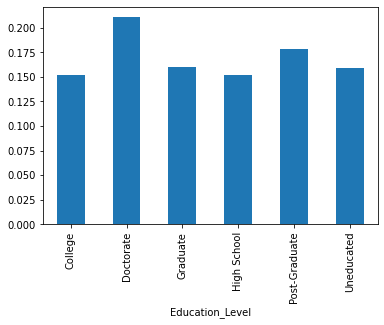

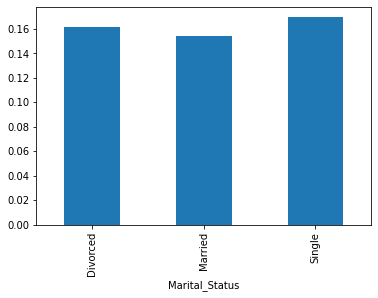

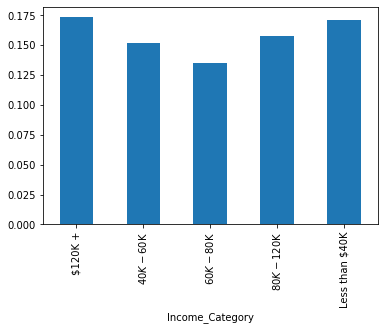

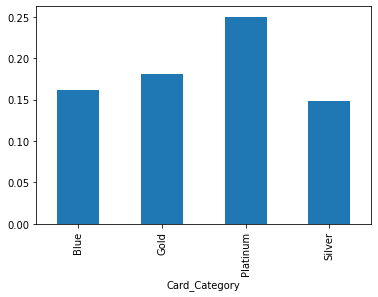

In [ ]:
for c in categorial:
  df.groupby(c).mean()['Churn'].plot(kind='bar')
  plt.show()

# Логистическая регрессия 

В данной части работы мы обучим модель логистической регрессии и оценим нашу точность. 

Перед началаом обучения разделим датасет на обучающую часть и на тестовую.

In [ ]:
import sklearn.linear_model
import sklearn.preprocessing

X = df[numerical+categorial]
Y = df['Churn']
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X,Y,test_size=0.2)


Здесь мы применим нужный скейлинг для больших числовых признаков и также закодируем категориальные ориентируясь на построенные гистограммы. 

In [ ]:
transformer = sk.compose.make_column_transformer(
    (sk.preprocessing.StandardScaler(), ['Customer_Age', 'Months_on_book', 'Total_Trans_Ct']),
    (sk.preprocessing.MinMaxScaler(), ['Total_Revolving_Bal']),
    (sk.preprocessing.OrdinalEncoder(categories=[['Married','Divorced','Single']]),['Marital_Status']),
    (sk.preprocessing.OrdinalEncoder(categories=[['$60K - $80K', '$40K - $60K', '$80K - $120K' , 'Less than $40K', '$120K +']]),['Income_Category']),
    (sk.preprocessing.OrdinalEncoder(categories=[['Silver', 'Blue', 'Gold' , 'Platinum']]),['Card_Category']),
    (sk.preprocessing.OneHotEncoder(), ['Education_Level']),
    remainder='passthrough'
)

X_trans = transformer.fit_transform(X_train[numerical+categorial])
X_trans_test = transformer.fit_transform(X_test[numerical+categorial])

Обучив модель проверим ее точность на тестовых данных. 

In [ ]:
model_trans = sk.linear_model.LogisticRegression().fit(X_trans, Y_train)

Y_P_trans = model_trans.predict(X_trans_test)

print(f"Accuracy={sk.metrics.accuracy_score(Y_test,Y_P_trans)}")

Accuracy=0.9146100691016782


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Для более детальной оценки точности мы построим матрицу ошибок. Вообщем, для данного метода результаты удовлетворительны. Однако чтобы получить более точные предсказания, следует воспользоваться другими видами моделей. 

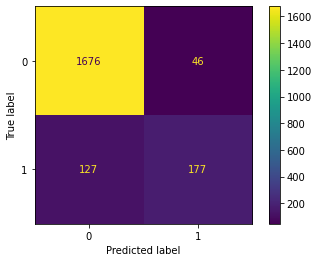

In [ ]:
sk.metrics.ConfusionMatrixDisplay.from_estimator(model_trans,X_trans_test,Y_test)
plt.show()

# Интерпретация модели

Рассмотрев коэффициенты можно понять как влияет каждый из признаков на отток пользователей. Например, чем больше кредитный лимит тем более высок шанс оттока. 

In [ ]:
list(zip(categorial+numerical, model_trans.coef_[0]))

[('Education_Level', 0.012335502646132753),
 ('Marital_Status', -0.08316926083406595),
 ('Income_Category', -3.2478370013970133),
 ('Card_Category', -0.7351123864355353),
 ('Customer_Age', 0.22188118085952066),
 ('Gender', 0.16914990761939316),
 ('Dependent_count', -0.4635952513779795),
 ('Months_on_book', -2.0474294706947096),
 ('Total_Relationship_Count', -1.7621732474391274),
 ('Months_Inactive_12_mon', -1.8862483385505948),
 ('Contacts_Count_12_mon', -2.000914061111321),
 ('Total_Revolving_Bal', -1.824161397649464),
 ('Total_Amt_Chng_Q4_Q1', -2.051979060702342),
 ('Total_Trans_Ct', 0.1583833962250939),
 ('Total_Ct_Chng_Q4_Q1', 0.17267343981729724),
 ('Avg_Utilization_Ratio', -0.48843362119446454),
 ('log_Credit_Limit', 0.3882792045475057),
 ('log_Avg_Open_To_Buy', 0.4683393428218778),
 ('log_Total_Trans_Amt', -1.0498471551190782)]

# DecisionTree

Теперь обучим новую модель дерева решений и оценим точность предсказаний.

In [ ]:
import sklearn.tree 

model = sk.tree.DecisionTreeClassifier().fit(X_trans,Y_train)
Y_pred = model.predict(X_trans_test)
sk.metrics.accuracy_score(Y_test,Y_pred)

0.9348469891411648

Можно сделать вывод, что данная модель справляется с задачей лучше чем предыдущая. 

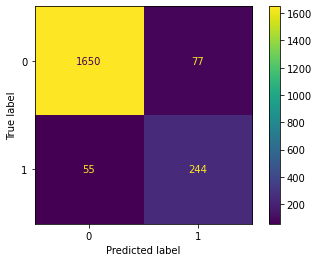

In [ ]:
sk.metrics.ConfusionMatrixDisplay.from_estimator(model,X_trans_test,Y_test)
plt.show()

# Интерпретация модели дерева решений

Чтобы интерпретировать данную модель, визуализируем дерево решений. Перед этим изменим список категориальных признаков на новый с учетом oneHotEncoding. Посмотрев на дерево, мы можем определить первый и самый важный признак, на который смотрит модель. Для нас это Dependent_Count. 

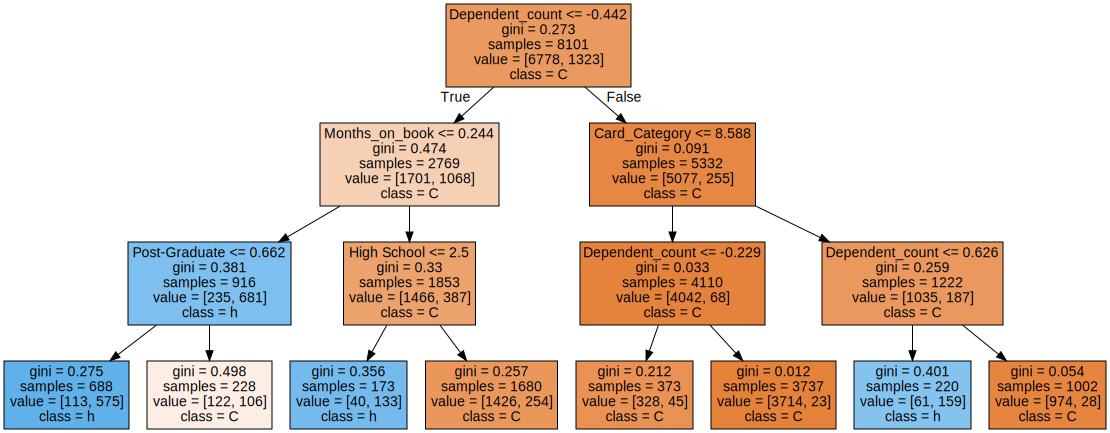

In [ ]:
from sklearn import tree
import graphviz

model = sk.tree.DecisionTreeClassifier(max_depth=3).fit(X_trans,Y_train)
oneHot_categorial = ['High School', 'Graduate', 'Uneducated',  'College', 'Post-Graduate', 'Doctorate', 'Marital_Status', 'Income_Category', 'Card_Category']

# DOT data
dot_data = tree.export_graphviz(model, out_file=None, 
                                feature_names=numerical+oneHot_categorial,  
                                class_names='Churn',
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

# BaggingClassifier

Также проверим еще одну модель.


In [ ]:
from sklearn.ensemble import BaggingClassifier

bgclassifier = BaggingClassifier(base_estimator=model, n_estimators=200,
                                 max_features=24,
                                 max_samples=8000,
                                 random_state=1, n_jobs=5)

bgclassifier.fit(X_trans,Y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_features=24,
                  max_samples=8000, n_estimators=200, n_jobs=5, random_state=1)

Обучается она намного дольше, однако дает результат чуть выше. Добавил чисто для себя, чтобы в будущем почитать про нее (наверное).

In [ ]:
print(bgclassifier.score(X_trans_test, Y_test))

0.9669299111549852


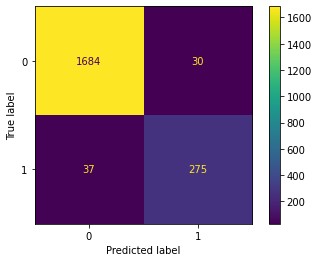

In [ ]:
sk.metrics.ConfusionMatrixDisplay.from_estimator(bgclassifier,X_trans_test,Y_test)
plt.show()